In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

%matplotlib inline

## Loading the data
We can now load the dataset into pandas using the read_csv() function. This converts the CSV file into a Pandas dataframe.

In [2]:
#Read in the csv file and convert to a Pandas dataframe
df_Football_Players = pd.read_csv("..\..\data\clean_data.csv")

In [3]:
df_Football_Players.shape

(9592, 23)

## Model




### Feature engineering: 

- Feature scaling
- Aggregation
- One hot coding

-------------------

In [55]:
df_Football_Players = df_Football_Players.drop(['name','player'],axis=1)

In [56]:
categorical_features = df_Football_Players.select_dtypes(include=object).columns
numeric_features = df_Football_Players.select_dtypes(include=np.number).columns
categorical_features

Index(['team', 'position'], dtype='object')

In [ ]:
# 2. Use NearestNeighbors to find the optimal eps
min_samples = 2

In [ ]:
df_Football_Players.head()

,Unnamed: 0,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,...,position_Defender Centre-Back,position_Defender Left-Back,position_Defender Right-Back,position_Goalkeeper,position_midfield,position_midfield-AttackingMidfield,position_midfield-CentralMidfield,position_midfield-DefensiveMidfield,position_midfield-LeftMidfield,position_midfield-RightMidfield
0,1,196.0,30.0,15,0.000000,0.000000,0.069018,0.0,0.0,1.242331,...,False,False,False,True,False,False,False,False,False,False
1,8,186.0,21.0,34,0.000000,0.000000,0.130529,0.0,0.0,0.000000,...,True,False,False,False,False,False,False,False,False,False
2,10,169.0,23.0,89,0.012619,0.063096,0.227145,0.0,0.0,0.000000,...,False,True,False,False,False,False,False,False,False,False
3,11,180.0,22.0,34,0.000000,0.033507,0.335071,0.0,0.0,0.000000,...,False,True,False,False,False,False,False,False,False,False
4,20,181.0,20.0,39,0.129125,0.064562,0.225968,0.0,0.0,0.000000,...,False,False,False,False,False,False,True,False,False,False


In [59]:
df_Football_Players.shape

(9592, 409)

#### 3. Feature selection


In [4]:
df_Football_Players = df_Football_Players[['appearance','minutes played','Unnamed: 0','current_value']]

In [5]:
df_Football_Players.shape

(9592, 4)

In [6]:
df_Football_Players.head()

,appearance,minutes played,Unnamed: 0,current_value
0,15,1304,1,1500000
1,34,2758,8,2000000
2,89,7132,10,22000000
3,34,2686,11,10000000
4,39,2788,20,800000


### Prepare train and test data


In [7]:
# Prepare data
X = df_Football_Players

# sacle the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [8]:
X.shape

(9592, 4)

### Build the model

In [138]:
# 2. Use NearestNeighbors to find the optimal eps
min_samples = 4

In [139]:
nn = NearestNeighbors(n_neighbors=min_samples)
nn.fit(X_scaled)
distances, indices = nn.kneighbors(X_scaled)

In [140]:
distances[:,min_samples-1]


array([0.24658196, 0.20902871, 0.65820608, ..., 0.1083099 , 0.09122373,
       0.11749361])

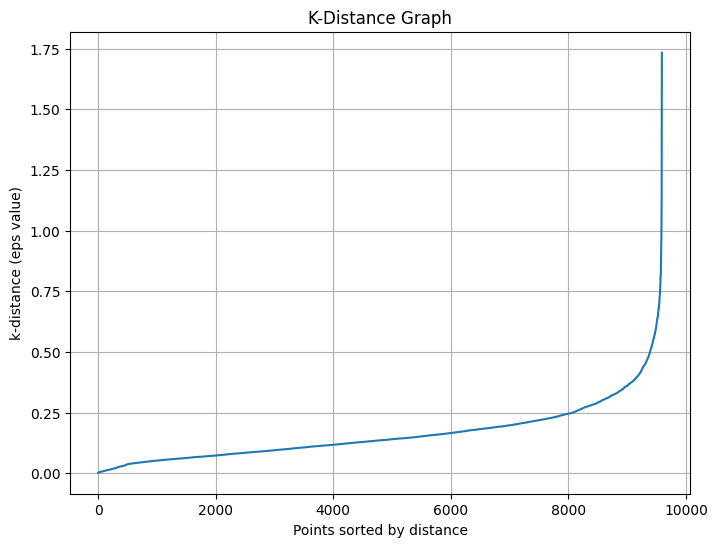

In [141]:
# The distance to the furthest neighbor (min_samples-th nearest) for each point
k_dist = distances[:, min_samples-1]

# Sort distances
k_dist_sorted = np.sort(k_dist)

# 3. Plotting the k-distance graph
plt.figure(figsize=(8, 6))
plt.plot(k_dist_sorted)
plt.title('K-Distance Graph')
plt.xlabel('Points sorted by distance')
plt.ylabel('k-distance (eps value)')
plt.grid(True)
plt.show()

In [162]:
# 4. Apply DBSCAN with chosen eps and min_samples
# Typically, you choose eps at the "elbow" point in this plot, where the slope changes significantly
chosen_eps = 0.32  # This is an example; choose this value based on the plot
dbscan = DBSCAN(eps=chosen_eps, min_samples=min_samples)

### Train and Test the Model

In [163]:
# Fit the model on the training data

clusters = dbscan.fit_predict(X_scaled)

In [164]:
pd.Series(clusters).value_counts()


 0     8860
-1      583
 5        9
 2        9
 3        8
 6        8
 19       8
 15       7
 24       7
 4        7
 11       7
 14       7
 1        6
 25       6
 13       6
 20       5
 12       5
 8        5
 9        5
 17       4
 16       4
 10       4
 18       4
 21       4
 23       4
 22       4
 7        3
 26       3
Name: count, dtype: int64

### Evaluating the Model

In [165]:
silhouette_avg = silhouette_score(X, clusters)
silhouette_avg

0.5057508192128995

In [166]:
X.head(2)


,appearance,minutes played,Unnamed: 0,current_value,dbscan
0,15,1304,1,1500000,0
1,34,2758,8,2000000,0


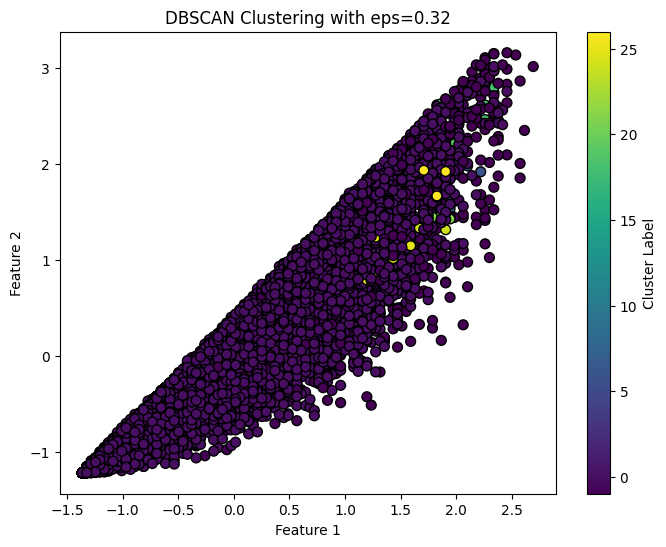

In [167]:
# 5. Plot the clustering result
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='viridis', s=50, edgecolor='k')
plt.title(f'DBSCAN Clustering with eps={chosen_eps}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()

In [168]:
X['dbscan'] = clusters


In [169]:
X['dbscan'].value_counts()

dbscan
 0     8860
-1      583
 5        9
 2        9
 3        8
 6        8
 19       8
 15       7
 24       7
 4        7
 11       7
 14       7
 1        6
 25       6
 13       6
 20       5
 12       5
 8        5
 9        5
 17       4
 16       4
 10       4
 18       4
 21       4
 23       4
 22       4
 7        3
 26       3
Name: count, dtype: int64

<Axes: xlabel='appearance', ylabel='current_value'>

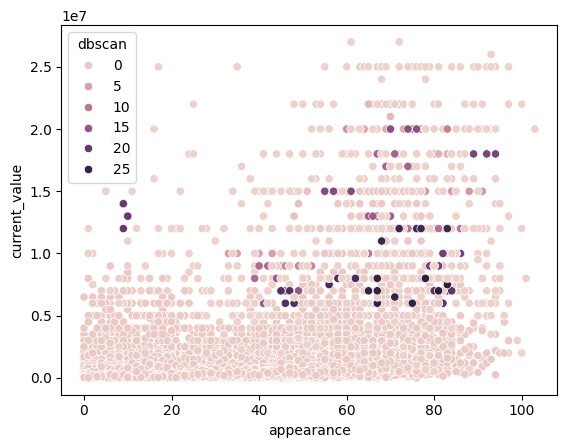

In [170]:
sns.scatterplot(data = X , x = 'appearance', y = 'current_value', hue = 'dbscan')

<Axes: xlabel='minutes played', ylabel='current_value'>

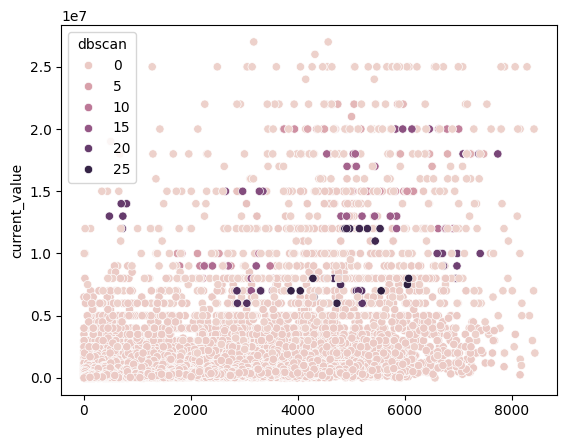

In [171]:
sns.scatterplot(data = X , x = 'minutes played', y = 'current_value', hue = 'dbscan')
